# Color quantization & first evaluation of color histogram classifier

## Loading the data

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from ipywidgets import interact
import ipywidgets as widgets

from dobble_master_race.toolkit import get_data_set

seed = 42 # Used for result reproductability

In [2]:
(X_train, Y_train), (X_test, Y_test) = get_data_set()
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((228,), (228,), (57,), (57,))

## What the data looks like ?

In [3]:
nb_class = np.max(Y_train)
nb_images_per_class = 4

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=nb_images_per_class, figsize=(12,4))
    for i, x in enumerate(X_train[Y_train == class_]):
        ax_arr[i].imshow(x)

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

# Color reduction

In this image classification problem, the image classes are significantly defined by their colors.\
Unfortunatly, the RGB space is way too broad and classifier will strugle to extract knowledge of it.\
Therefore, a preprocessing that reduces the numbers of colors, without sacrificing too much on the color description of class, will significantly improve its performance.

## Image mask
We are only interested in the colors from the image, not the blank background.\
We then need masks to extract the object from each images.

In [11]:
gray_threshold = 245

masks_train = np.array([
    img.sum(axis=-1) < (gray_threshold * 3)
    for img in X_train
], dtype=object)


masks_test = np.array([
    img.sum(axis=-1) < (gray_threshold * 3)
    for img in X_test
], dtype=object)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=nb_images_per_class, figsize=(12,4))
    for i, mask in enumerate(masks_train[Y_train == class_]):
        ax_arr[i].imshow(mask, cmap='gray')

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Sampling pixels
KMeans can a be a quite slow algorithm on large dataset. And in this application, we have `285` images * `~150x150` pixels per image = 6M+ pixels in total.\
Let's sample the number of pixels that will represent our dataset to make it faster.

In [6]:
nb_sample = 50000

nb_images = nb_class * nb_images_per_class
nb_sample_per_image = nb_sample // nb_images

sample_pxls = X_train[0][masks_train[0]][0] # Initialize arbitrary to be able to use np.vstack
for img, mask in zip(X_train[1:], masks_train[1:]):
    pxls = img[mask]
    new_sample_pxls_id = np.random.choice(pxls.shape[0], size=nb_sample_per_image, replace=False)
    sample_pxls = np.vstack((sample_pxls, pxls[new_sample_pxls_id]))

sample_pxls.shape, sample_pxls.dtype

((49714, 3), dtype('uint8'))

## Selecting color quantization threshold

In [7]:
from sklearn.cluster import KMeans
from tqdm import tqdm

# How to choose the right number of colors ?

inertias = []
new_colors = []
color_models = []
color_range = (2, 40)

# Compute new_colors and inertias and color_models
for i in tqdm(range(*color_range)):
    kmeans = KMeans(n_clusters=i, random_state=seed)
    
    kmeans.fit(sample_pxls)
    inertias.append(kmeans.inertia_)
    
    new_color = kmeans.cluster_centers_.astype(np.uint8)
    new_colors.append(new_color)
    
    color_models.append(kmeans)

100%|█████████████████████████████████████████████████████████████████████| 38/38 [05:04<00:00,  8.01s/it]


/tmp/ipykernel_73009/3318355550.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_arr[1].set_xticklabels([1, 2, 7, 12, 17, 22, 27, 32, 37])


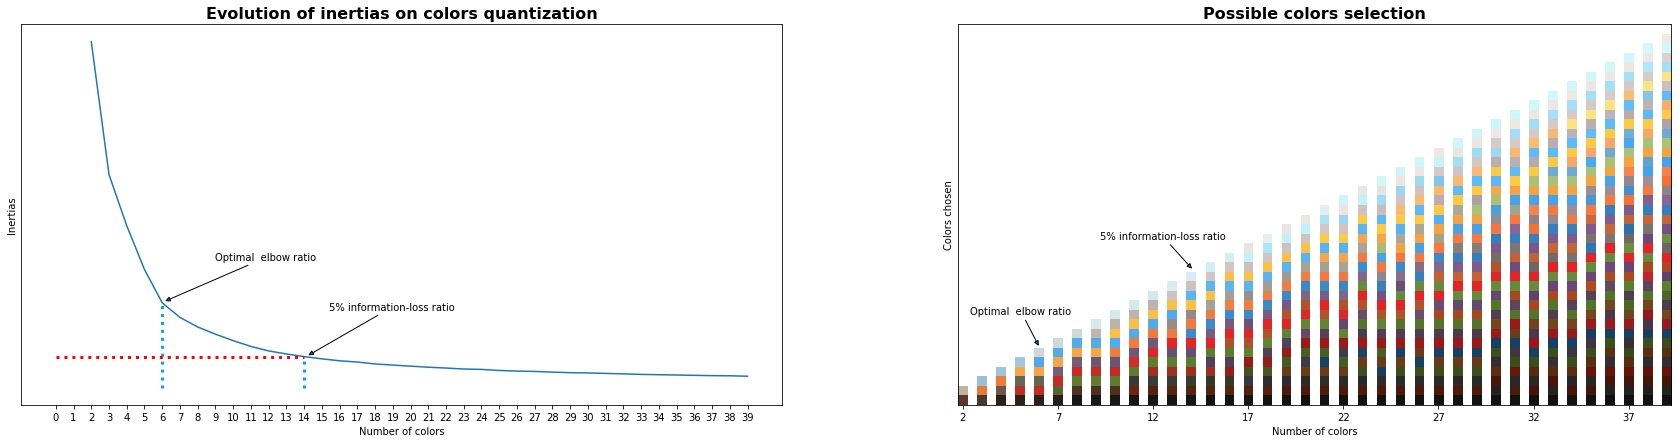

In [65]:
# Elbow optimum
nb_opti_color = 6

# Information threshold optimum
info_loss_threshold = 0.05 * (max(inertias) - min(inertias)) + min(inertias) # Accept 5% loss
info_loss_opti_color = np.searchsorted(-np.array(inertias), -info_loss_threshold, side="left")

# Figure
_, ax_arr = plt.subplots(ncols=2, figsize=(30,7))

# Plot new_colors
nb_tested_colors = color_range[1] - color_range[0]
new_color_img = np.full(shape=(color_range[1], 2 * nb_tested_colors - 1, 3), fill_value=255)

for i, new_color in enumerate(new_colors):
    new_color_img[:new_color.shape[0], i * 2] = np.array(sorted(new_color, key=lambda color: color[0] / 3 + color[1] / 3 + color[2] / 3))[np.newaxis, ...]

ax_arr[1].imshow(new_color_img, origin='lower')
ax_arr[1].set_title("Possible colors selection", fontsize=16, fontweight="semibold")
ax_arr[1].set_xlabel("Number of colors")
ax_arr[1].set_ylabel("Colors chosen")
ax_arr[1].set_xticklabels([1, 2, 7, 12, 17, 22, 27, 32, 37])
ax_arr[1].set_yticklabels([]); ax_arr[1].set_yticks([])
ax_arr[1].annotate(r"5% information-loss ratio", xy=((info_loss_opti_color - 2) * 2 * 1.01, (info_loss_opti_color - 1) * 1.05),
                   xytext=((info_loss_opti_color - 2 ) * 2 * 0.6, (info_loss_opti_color - 1) * 1.3), arrowprops=dict(arrowstyle="-|>"))
ax_arr[1].annotate(r"Optimal  elbow ratio", xy=((nb_opti_color - 2) * 2 * 1.01, (nb_opti_color - 1) * 1.1),
                   xytext=((nb_opti_color - 2 ) * 2 * 0.1, (nb_opti_color - 1) * 1.8), arrowprops=dict(arrowstyle="-|>"))

# Plot inertias
ax_arr[0].plot(range(*color_range), inertias)
ax_arr[0].set_title("Evolution of inertias on colors quantization", fontsize=16, fontweight="semibold")
ax_arr[0].set_xlabel("Number of colors")
ax_arr[0].set_ylabel("Inertias")
ax_arr[0].set_yticklabels([]); ax_arr[0].set_yticks([])
ax_arr[0].set_xticks(range(color_range[-1]))
ax_arr[0].plot([nb_opti_color, nb_opti_color],[0, inertias[nb_opti_color - color_range[0]]],':', color = '#00aadd', lw=3)
ax_arr[0].annotate(r"Optimal  elbow ratio", xy=(nb_opti_color * 1.01, inertias[nb_opti_color - color_range[0]] * 1.01),
                   xytext=(nb_opti_color * 1.5, inertias[nb_opti_color - color_range[0]] * 1.5), arrowprops=dict(arrowstyle="-|>"))
ax_arr[0].plot([0, info_loss_opti_color],[inertias[info_loss_opti_color - color_range[0]], inertias[info_loss_opti_color - color_range[0]]],':', color = '#ff0000', lw=3)
ax_arr[0].annotate(r"5% information-loss ratio", xy=(info_loss_opti_color * 1.01, inertias[info_loss_opti_color - color_range[0]] * 1.01),
                   xytext=(info_loss_opti_color * 1.1, inertias[info_loss_opti_color - color_range[0]] * 2.5), arrowprops=dict(arrowstyle="-|>"))
ax_arr[0].plot([info_loss_opti_color, info_loss_opti_color],[0, inertias[info_loss_opti_color - color_range[0]]],':', color = '#00aadd', lw=3);

There are usually 2 approaches to choose a color quantization threshold:
- Elbow method: Find an optimal $\frac{information-loss}{complexity}$ ratio
- Threshold method: Use a information-loss acceptance threshold (e.g. 5%)

We can see here, the two ratios in action.

Here, we can see on the left, the inertias curve for the number of colors selected. Based on the elbow method, we can say that a number of colors of 6 seems to be an optimal ratio between information lost (a.k.a inertias) and high complexity (a.k.a high number of colors).

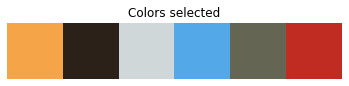

In [9]:
# Example of color sampling
nb_color = nb_opti_color

color_model = color_models[nb_color - color_range[0]]
new_color_lut = new_colors[nb_color - color_range[0]]

plt.imshow(new_color_lut[np.newaxis, :, :]); plt.axis("off"); plt.title("Colors selected");

In [13]:
import sklearn

def get_color_maps(X: np.array, masks: np.array, color_model: sklearn.cluster) -> np.array:
    return np.array([
        color_model.predict(img[mask])
        for img, mask in zip(X, masks)
    ], dtype=object)

color_maps_train = get_color_maps(X_train, masks_train, color_model)

def get_recolored_img(img: np.array, mask: np.array, color_map: np.array, *, background_color=255) -> np.array:
    recolored_img = np.full_like(img, background_color)
    recolored_img[mask] = new_color_lut[color_map]
    
    return recolored_img

def recolor_X(X: np.array, masks: np.array, color_model: sklearn.cluster, *, color_maps: np.array = None) -> np.array:
    if (color_maps is None):
        color_maps = get_color_maps(X, masks, color_model)
        
    return np.array([
        get_recolored_img(img, mask, color_map)
        for img, mask, color_map in zip(X, masks, color_maps)
    ], dtype=object)

recolored_X_train = recolor_X(X_train, masks_train, color_model)
recolored_X_test  = recolor_X(X_test,  masks_test, color_model)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    fig = plt.figure(constrained_layout=True, figsize=(12,4))
    subfigs = fig.subfigures(nrows=2, ncols=1)
    ax_recolored = subfigs[0].subplots(nrows=1, ncols=nb_images_per_class); subfigs[0].suptitle("Recolored", fontsize=16)
    ax_original  = subfigs[1].subplots(nrows=1, ncols=nb_images_per_class); subfigs[1].suptitle("Original", fontsize=16)
    
    for i, (recolored_x, x) in enumerate(zip(recolored_X_train[Y_train == class_], X_train[Y_train == class_])):
        ax_recolored[i].imshow(recolored_x)
        ax_original[i].imshow(x)
        ax_recolored[i].axis("off"); ax_original[i].axis("off")

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

Regardons de plus prêt les effets de la color quantization sur nos images. On peut voir que le seuil actuel de color quantization modifie significativement certaines images.\
C'est notamment le cas sur les images de la class 10, représentant un point d'intérogation. En effet, le léger bruit qu'il y avait dans notre image orignial est significativement amplifié.\
On peut se demander les effets que cela peut avoir sur les performances de notre classifier. Nous étudierons et mesurerons cet effet plus tard.

## Color descriptor
We now need to find an appropriate color descriptor. \
The color histogram is usually a good choice in this case as it is both really compact and discriminative. We will also see, that the noise of the color quantization won't impact that much the performance of the classifier on the color histogram.

### Computation of the color histograms

In [70]:
def get_hist(color_map: np.array, *, nb_color=nb_color) -> np.array:
    hist = np.bincount(color_map, minlength=nb_color)
    norm_hist = hist / color_map.shape[0]
    
    return norm_hist

def compute_histograms(color_maps: np.array, *, nb_color=nb_color) -> np.array:
    return np.array([get_hist(color_map, nb_color=nb_color) for color_map in color_maps], dtype=object)

color_histograms_train = compute_histograms(color_maps_train)
color_histograms_train = compute_histograms(color_maps_train)

colors_for_bars = new_color_lut / 255  # matplotlib colors are RGB values scaled to [0,1]

@interact(x_index=widgets.BoundedIntText(max=X_train.shape[0]))
def show_histograms(x_index: int) -> None:
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1)
    plt.imshow(X_train[x_index])
    plt.axis('off'); plt.title("Original")
    plt.subplot(1,3,2)
    plt.imshow(recolored_X_train[x_index])
    plt.axis('off'); plt.title("Recolored")
    plt.subplot(1,3,3, aspect=len(color_histograms_train[0]))
    plt.ylim(0, 1)
    plt.bar(range(len(color_histograms_train[x_index])), 
            color_histograms_train[x_index] / color_histograms_train[x_index].max(), 
            color=colors_for_bars)
    plt.xticks([]); plt.title("Histogram")
    plt.show()

interactive(children=(BoundedIntText(value=0, description='x_index', max=228), Output()), _dom_classes=('widge…

# Classifier base on image color histogram

## Metrics
We base our evaluation system on solid, well-knowed metrics:
- F1-score
- Confusion Matrix

As all the classes have the same number of samples in it, we choose to compute the f1-score with a `micro` mean.

To mitigate the effect of the small size of the dataset on the evaluation, we have chosen to use a 4-cross-validation.\
This will keep under-control the high variance of performance such a dataset could have.\
The 5-cross-validation automatically separates the training and the testing set and evaluates the model on it for 5 different configuration.\
Checkout the [wikipedia page](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) to know more.

In [99]:
import pandas as pd
import seaborn as sn
from sklearn.model_selection import cross_validate

def print_confusion_matrix(predicted: np.array, actual: np.array) -> None:
    """
    Print the confusion matrix for the `predicted` outputs vs the `actual` ones.
    """
    old_figsize = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (15,15)
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=True, bottom=True, top=True, labeltop=True)
    sn.heatmap(confusion_matrix, annot=True, vmax=np.max(confusion_matrix.max()[:-1]))
    plt.show()
    plt.rcParams["figure.figsize"] = old_figsize

def get_perf_on_cross_validation(model) -> None:
    """
    Compute & print the following metrics with an average on a 5-cross-validation for the given `model`:
    - F1-score
    - Confusion Matrix
    """
    model_perf = cross_validate(model, color_histograms_train, Y_train, cv=nb_images_per_class,
                                scoring=['f1_micro'], return_estimator=True)
    best_model = model_perf["estimator"][np.argmax(model_perf["test_f1_micro"])]
    print(f"F1-score: {np.mean(model_perf['test_f1_micro'])}")
    
    print_confusion_matrix(best_model.predict(color_histograms_train), Y_train)    

### Dummy baseline
The goal of this baseline is to illustrate the performance of a random classifier.
This will demonstrate the performance of our implementation.

In [ ]:
class DummyClassifier:
    """
    Return a random class for each entry
    """
    def fit(self, X: np.array, Y: np.array) -> "DummyClassifier":
        return self
    
    def get_params(self, deep=True) -> dict:
        return {}
    
    def predict(self, X: np.array) -> np.array:
        return np.random.randint(low=1, high=nb_class + 1, size=X.shape[0])

dummy = DummyClassifier()
get_perf_on_cross_validation(dummy)

F1-score: 0.02631578947368421


## The classifiers
We based our choice of classifiers on the sklearn cheat-sheet.\
As we are in a classification problem and that we have less than 100k samples, we tried the following classifiers:
- LinearSVC
- KNN
- SVC
- Random Forest

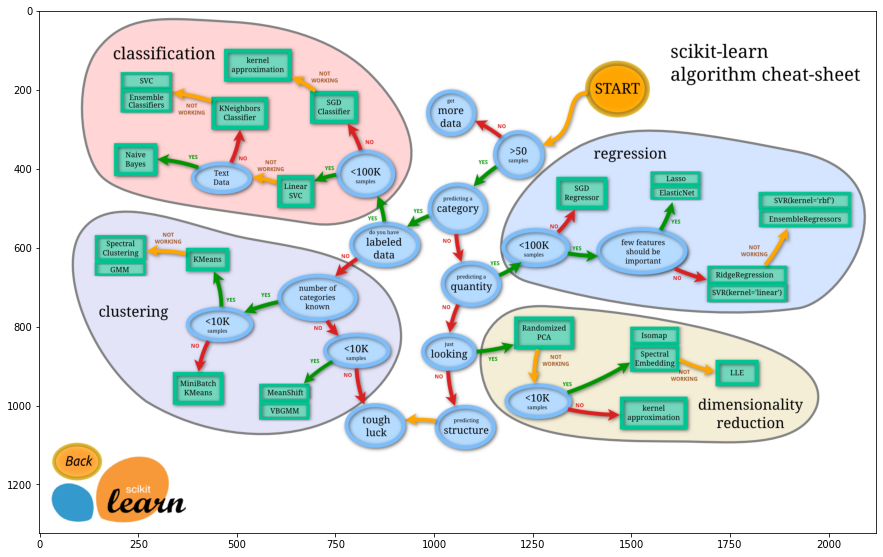

In [81]:
from PIL import Image
import urllib
from matplotlib import pyplot as plt

img = np.array(Image.open(urllib.request.urlopen("https://scikit-learn.org/stable/_static/ml_map.png")))
old_fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(img)
plt.rcParams["figure.figsize"] = old_fig_size;

In [82]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
cross_validate(linear_svc, color_histograms_train, Y_train, cv=nb_images_per_class)["test_score"]

array([0.28070175, 0.24561404, 0.26315789, 0.24561404])

In [83]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_models = cross_validate(knn, color_histograms_train, Y_train, cv=nb_images_per_class, return_estimator=True)
best_knn = knn_models["estimator"][np.argmax(knn_models["test_score"])]
knn_models["test_score"]

array([0.85964912, 0.8245614 , 0.8245614 , 0.8245614 ])

In [84]:
from sklearn.svm import SVC

svc = SVC()
svc_models = cross_validate(svc, color_histograms_train, Y_train, cv=nb_images_per_class, return_estimator=True)
best_svc = svc_models["estimator"][np.argmax(svc_models["test_score"])]
svc_models["test_score"]

array([0.8245614 , 0.85964912, 0.85964912, 0.85964912])

Recall: 0.8508771929824561
Precision: 0.8508771929824561
F1-score: 0.8508771929824561


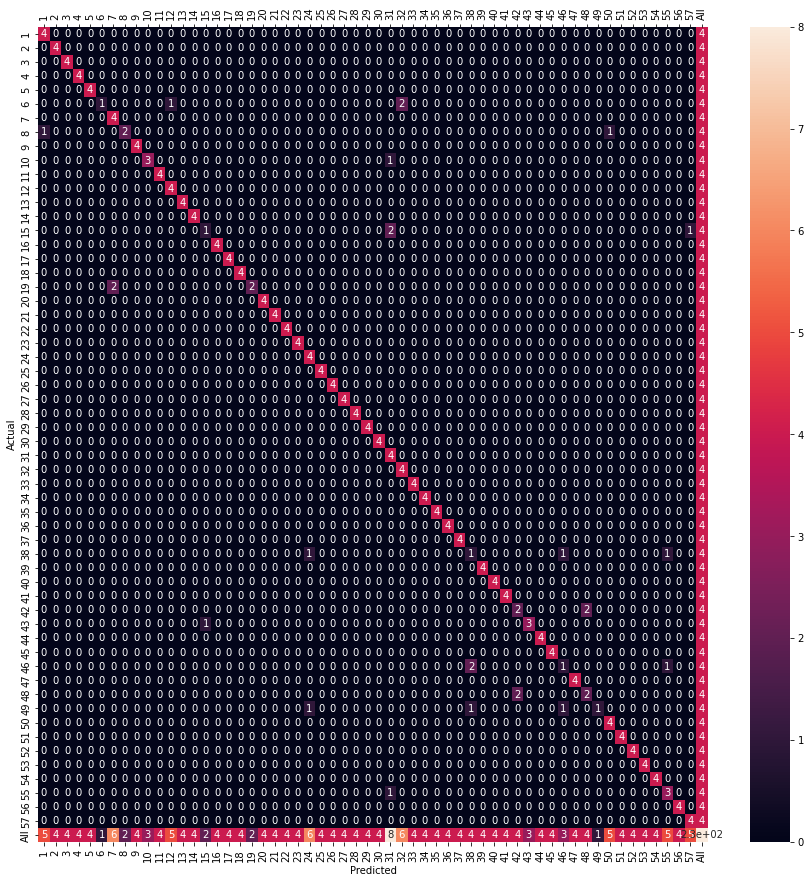

In [85]:
get_perf_on_cross_validation(svc)

On voit la class 6 (Le bon homme de neige) est confondu avec les class 12 et 32, respectivement le Fantome et le Crayon.
Ce qui est logique comme ils ont tous les 3 des couleurs tres similaires.

## Peut-on ameliorer les resultats du classifier en changeant la color quanitzation ?

In [87]:
def recolor_and_compute_histograms(X: np.array, masks: np.array, color_model: sklearn.cluster, *, nb_color) -> np.array:
    color_maps = get_color_maps(X, masks, color_model)
    return compute_histograms(color_maps, nb_color=nb_color)

def get_score(classifier, color_histograms: np.array, Y: np.array) -> float:
    return np.mean(cross_validate(classifier, color_histograms, Y, cv=nb_images_per_class)["test_score"])

linear_svc_perf = []
svc_perf = []
knn_perf = []

for nb_color, color_model in tqdm(list(enumerate(color_models, start=color_range[0]))):
    new_color_histograms = recolor_and_compute_histograms(X_train, masks_train, color_model, nb_color=nb_color)
    linear_svc_perf.append(get_score(linear_svc, new_color_histograms, Y_train))
    svc_perf.append(get_score(svc, new_color_histograms, Y_train))
    knn_perf.append(get_score(knn, new_color_histograms, Y_train))

100%|█████████████████████████████████████████████████████████████████████| 38/38 [00:39<00:00,  1.05s/it]


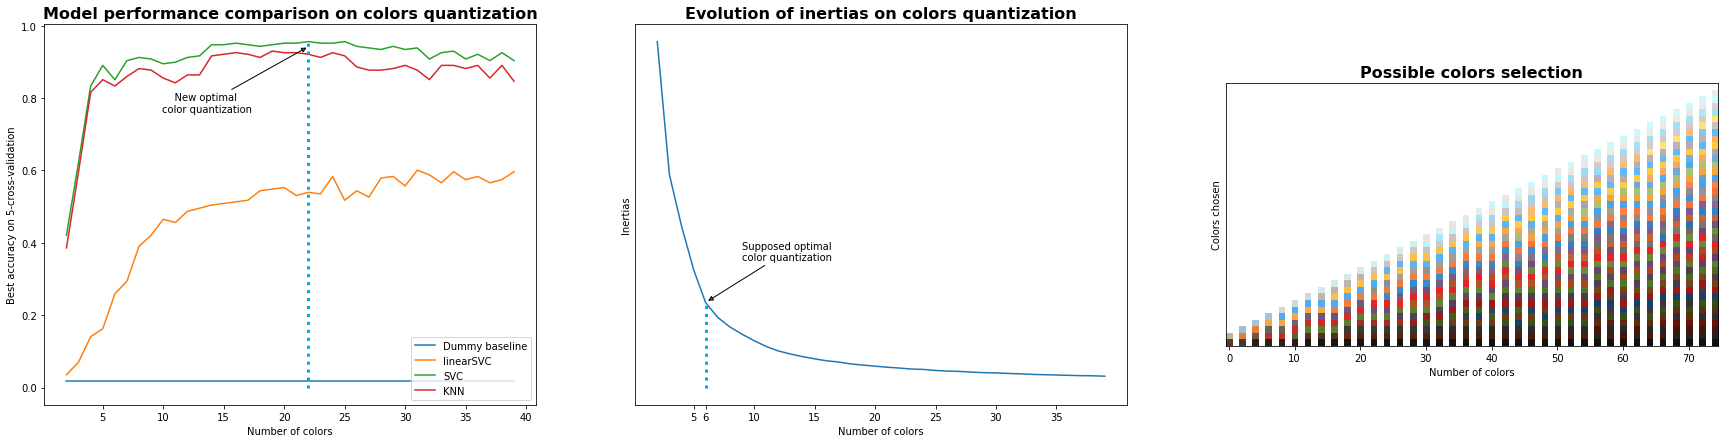

In [88]:
nb_opti_color = 6
_, ax_arr = plt.subplots(ncols=3, figsize=(30,7))
    
# Plot new_colors
nb_tested_colors = color_range[1] - color_range[0]
new_color_img = np.full(shape=(color_range[1], 2 * nb_tested_colors - 1, 3), fill_value=255)

for i, new_color in enumerate(new_colors):
    new_color_img[:new_color.shape[0], i * 2] = np.array(sorted(new_color, key=lambda color: color[0] / 3 + color[1] / 3 + color[2] / 3))[np.newaxis, ...]

ax_arr[2].imshow(new_color_img, origin='lower')
ax_arr[2].set_title("Possible colors selection", fontsize=16, fontweight="semibold")
ax_arr[2].set_xlabel("Number of colors")
ax_arr[2].set_ylabel("Colors chosen")
ax_arr[2].set_yticklabels([]); ax_arr[2].set_yticks([])

# Plot inertias
ax_arr[1].plot(range(*color_range), inertias)
ax_arr[1].set_title("Evolution of inertias on colors quantization", fontsize=16, fontweight="semibold")
ax_arr[1].set_xlabel("Number of colors")
ax_arr[1].set_ylabel("Inertias")
ax_arr[1].set_yticklabels([]); ax_arr[1].set_yticks([])
ax_arr[1].set_xticks(list(range(0, color_range[-1], 5)) + [6])
ax_arr[1].plot([nb_opti_color, nb_opti_color],[0, inertias[nb_opti_color - color_range[0]]],':', color = '#00aadd', lw=3)
ax_arr[1].annotate("Supposed optimal\ncolor quantization", xy=(nb_opti_color * 1.01, inertias[nb_opti_color - color_range[0]] * 1.01),
                   xytext=(nb_opti_color * 1.5, inertias[nb_opti_color - color_range[0]] * 1.5), arrowprops=dict(arrowstyle="-|>"))

# Plots classifiers performance
new_nb_opti_color = np.argmax(svc_perf) + color_range[0]
ax_arr[0].set_title("Model performance comparison on colors quantization", fontsize=16, fontweight="semibold")
ax_arr[0].set_xlabel("Number of colors")
ax_arr[0].set_ylabel("Best accuracy on 5-cross-validation")
ax_arr[0].plot(range(*color_range), [1 / nb_class] * (color_range[1] - color_range[0]), label="Dummy baseline")
ax_arr[0].plot(range(*color_range), linear_svc_perf, label="linearSVC")
ax_arr[0].plot(range(*color_range), svc_perf, label="SVC")
ax_arr[0].plot(range(*color_range), knn_perf, label="KNN")
ax_arr[0].legend(loc="lower right")
ax_arr[0].plot([new_nb_opti_color, new_nb_opti_color],[0, svc_perf[new_nb_opti_color - color_range[0]]],':', color = '#00aadd', lw=3)
ax_arr[0].annotate("    New optimal\ncolor quantization", xy=(new_nb_opti_color, svc_perf[new_nb_opti_color] * 0.99),
                   xytext=(new_nb_opti_color * 0.45, svc_perf[new_nb_opti_color] * 0.8), arrowprops=dict(arrowstyle="-|>"));

First, it is good to note that all classifiers largely outperforms the dummy baseline.\
Also, the SVC seems to outperforms the KNN and LinearSVC methods for higher color quantization. \
We can also see that beyond a color quantization of 15 colors, the models does not seems to improve anymore (and even starts to underperform for KNN and SVC). \
Therefore, we will keep this threashold for latter experiments, as it seems to ne an optimal threashold between precision and performance.